In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import math
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from scipy.optimize import curve_fit
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

C:\Users\agata\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# --- Basic Linear Regression Class
class _LinRegBasicModel:
  def __init__(self, Y, X, echo=False):
    if echo:
      print("TASK: Build linear regression model...")
    # --- Type check for X
    if echo:
      print("  1. Validating data.")
    if isinstance(X, np.ndarray):
      if len(X.shape) == 1:
        self.p = 2
      else:
        self.p = X.shape[1] + 1
      self.n = X.shape[0]
      self.X = np.c_[np.repeat(1, self.n).reshape(self.n, 1), X]
      self.var_names = ["Intercept"] + [f"V{i}" for i in range(1, self.p)]
    elif isinstance(X, pd.DataFrame):
      self.p = X.shape[1] + 1
      self.n = X.shape[0]
      self.X = np.c_[np.repeat(1, self.n).reshape(self.n, 1), X.to_numpy()]
      if list(X.columns) == [i for i in range(len(X.columns))]:
        self.var_names = ["Intercept"] + [f"V{i}" for i in range(1, self.p)]
      else:
        self.var_names = ["Intercept"] + list(X.columns)
    elif isinstance(X, pd.Series):
      self.p = 2
      self.n = X.shape[0]
      self.X = np.c_[np.repeat(1, self.n).reshape(self.n, 1), X.to_numpy().reshape((self.n, 1))]
      self.var_names = ["Intercept", "X"]
    else:
      print("Unsupported data matrix (X) type:", type(X))

    # --- Check if Y has the same length as data
    if echo:
      print("  2. Validating response vector.")
    if isinstance(Y, np.ndarray):
      if len(Y.shape) == 1:
        if Y.shape[0] != self.n:
          raise ValueError("Value vector (Y) has different length that data (X).")
        self.Y = Y.reshape(self.n, 1)
      elif len(Y.shape) == 2:
        if Y.shape[0] != self.n:
          raise ValueError("Value vector (Y) has different length that data (X).")
        if Y.shape[1] != 1:
          raise ValueError("Your value vector (Y) has more that one column.")
        self.Y = Y.reshape(self.n, 1)
      else:
        raise ValueError("Your value vector is invalid.")
      self.var_names = ["Y"] + self.var_names
    elif isinstance(Y, pd.DataFrame):
      if Y.shape[0] != self.n:
        raise ValueError("Value vector (Y) has different length that data (X).")
      self.Y = Y.to_numpy()
      if Y.columns[0] == 0:
        self.var_names = ["Y"] + self.var_names
      else:
        self.var_names = [Y.columns[0]] + self.var_names
    elif isinstance(Y, pd.Series):
      if Y.shape[0] != self.n:
        raise ValueError("Value vector (Y) has different length that data (X).")
      self.Y = Y.to_numpy().reshape((self.n, 1))
      self.var_names = ["Y"] + self.var_names

    # Informative form of data
    self.data_matrix = pd.DataFrame(np.c_[self.Y, self.X], columns=self.var_names)

    # SVD decomposition
    if echo:
      print("  3. Decomposing X with using SVD method.")
    self.U, self.D, self.Vt = np.linalg.svd(self.X, full_matrices=False)

    # Calculate estimators
    if echo:
      print("  4. Calculating LSM estimators.")
    self.XX_inv = self.Vt.transpose() @ np.diag(1 / (self.D * self.D)) @ self.Vt
    self.beta = np.squeeze(self.XX_inv @ (self.X.transpose() @ self.Y))

    # Hat matrix and prediction
    if echo:
      print("  5. Calculating hat matrix and Y predictions.")
    self.H = self.U @ self.U.transpose()
    self.Y_pred = self.H @ self.Y

    # Rating the model
    if echo:
      print("  6. Rating the model.")
    self.SST = Y.transpose() @ Y - self.n * Y.mean()
    self.SSE = (Y.transpose() @ Y - Y.transpose() @ self.Y_pred)[0]
    self.SSR = self.SST - self.SSE
    self.R2 = self.SSR / self.SST
    self.R2_adj = 1 - self.SSE * (self.n - 1) / self.SST / (self.n - self.p)

    # Estimators and statistics
    if echo:
      print("  7. Estimating error and calculating statistics.")
    self.S2 = self.SSE / (self.n - self.p)
    self.SE_beta = np.sqrt(self.S2 * np.diag(self.XX_inv))
    self.F_stat = self.SSR * (self.n - self.p) / self.SSE / (self.p - 1)
    self.F_stat_pvalue = 1 - stats.f(self.p - 1, self.n - self.p).cdf(self.F_stat)
    self.t_stat = self.beta / self.SE_beta
    self.t_stat_pvalues = 2 * (1 - stats.t(self.n - self.p).cdf(np.abs(self.t_stat)))

    # Calculating residuals
    if echo:
      print("  8. Calculating residuals.\n")
    self._res = np.squeeze(self.Y - self.Y_pred)
    self._res_stud = self._res / np.sqrt(self.S2 * (1 - np.diag(self.H)))
    self._res_mod = self._res / (1 - np.diag(self.H))
    self._res_mod_stud = self._res_mod / np.sqrt(((self.n - self.p) * (1 - np.diag(self.H)) * self.S2 - self._res ** 2) / (self.n - self.p - 1))
    self.cook_dist = self._res_mod * np.diag(self.H) / self.p / (1 - np.diag(self.H))
    self.residuals = pd.DataFrame({
      "fitValue": self.Y_pred.squeeze(),
      "Residue": self._res,
      "stdResidue": self._res_stud,
      "modResidue": self._res_mod,
      "modStdResidue": self._res_mod_stud,
      "CooksDist": self.cook_dist
    })

  def summary(self):
    max_var_length = max([len(v) for v in self.var_names[1:]])
    # Header
    print(" " * max_var_length + "      Estimate    Std.Error     t.stats     p-value")

    # Estimators
    for i in range(len(self.beta)):
      mark = ""
      if self.t_stat_pvalues[i] <= 0.1:
        mark = '.'
      if self.t_stat_pvalues[i] <= 0.05:
        mark = "*"
      if self.t_stat_pvalues[i] <= 0.001:
        mark = "**"
      if self.t_stat_pvalues[i] <= 0.000001:
        mark = "***"
      print(f"{self.var_names[i + 1]:{max_var_length}}", "  -" if self.beta[i] < 0 else "   ", f"{abs(self.beta[i]):.5e}",
            "  {0:11.4f}".format(self.SE_beta[i]), "  {0:10.4f}".format(self.t_stat[i]), "  {0:10.6f}".format(self.t_stat_pvalues[i]),
            " ", mark, sep="")

    # Info
    print()
    print("(.): p <= 0.1  (*): p <= 0.05  (**): p <= 0.001  (***): p <= 1e-6")
    print()
    print("Variance explanation %:")
    print("  R2: {0:7.7f}".format(self.R2), "     R2 adj.: {0:7.7f}".format(self.R2_adj))
    print()
    print("F-statistics result. H0: all predictors are equal to zero.")
    print("  F: {0:10.4f}".format(self.F_stat), "with p-value: {0:6.6f}".format(self.F_stat_pvalue), f"on ({self.p - 1}, {self.n - self.p}) degree of freedom.")
    print()
    print("Error estimator: {0:10.4f}".format(self.S2))

    if len(np.diag(self.H) >= 2 * self.p / self.n) > 0:
      print()
      print("There are some influential observations. Average influence:", 2 * self.p / self.n)
      print(pd.concat([self.data_matrix.loc[np.diag(self.H) >= 2 * self.p / self.n, self.data_matrix.columns != "Intercept"].reset_index(),
                       pd.DataFrame({"h_ii": np.diag(self.H)[np.diag(self.H) >= 2 * self.p / self.n]})], axis=1))

    if len(abs(self._res_mod_stud) > 2):
      print()
      print("There might be a few protruding observations.")
      print(pd.concat([self.data_matrix.loc[abs(self._res_mod_stud) > 2, self.data_matrix.columns != "Intercept"],
                       self.residuals.loc[abs(self._res_mod_stud) > 2, "modStdResidue"]], axis=1).reset_index())
      print("Consider removing some of them to obtain better model.")

  def print_data_matrix(self):
    print(self.data_matrix)

In [3]:
signals = pd.read_csv("data/train/wind-farm-1-signals-training.csv", sep=";")
signals = signals[["Turbine_ID", "Timestamp", "Grd_Prod_Pwr_Avg", "Amb_WindSpeed_Avg", "Amb_Temp_Avg", "Nac_Temp_Avg", "Rtr_RPM_Avg", "Gear_Bear_Temp_Avg", "Gen_RPM_Avg", "Gen_Bear2_Temp_Avg", "Gen_Bear_Temp_Avg"]]
signals["Timestamp_Datetime"] = pd.to_datetime(signals.Timestamp)
signals.Timestamp_Datetime = signals.Timestamp_Datetime.apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second))
signals_T01 = signals.loc[signals.Turbine_ID == "T01"]
signals_T06 = signals.loc[signals.Turbine_ID == "T06"]
signals_T07 = signals.loc[signals.Turbine_ID == "T07"]
signals_T09 = signals.loc[signals.Turbine_ID == "T09"]
signals_T11 = signals.loc[signals.Turbine_ID == "T11"]

In [4]:
def slice_signals(signals_source, turbine_id, wind_bins = np.arange(4, 10.5, 0.5), temp_bins = [4, 15, 19, 24, 41]):
    indices = signals_source.loc[signals_source.Turbine_ID == turbine_id, :].index
    wind = pd.cut(signals_source.loc[signals_source.Turbine_ID == turbine_id, :].Amb_WindSpeed_Avg, bins = np.arange(4, 10.5, 0.5))
    temp = pd.cut(signals_source.loc[signals_source.Turbine_ID == turbine_id, :].Amb_Temp_Avg, bins = temp_bins)
    segments = pd.DataFrame({
        "Wind": wind, 
        "Temp": temp, 
        "Power": signals_source.loc[signals_source.Turbine_ID == turbine_id, :].Grd_Prod_Pwr_Avg, 
        "Time": signals_source.loc[signals_source.Turbine_ID == turbine_id, :].Timestamp_Datetime
    })
    return segments.dropna().loc[segments.Power >= 10, :].sort_values(by = ["Wind", "Temp", "Time"])

In [5]:
batch_size = 30
for i, (name, group) in enumerate(slice_signals(signals, "T01", temp_bins=[4, 15, 20, 25, 30, 41]).groupby(by = ["Temp", "Wind"])):
    temp = group.reset_index()
    group_id = np.repeat(np.arange(0, temp.shape[0] // batch_size + 1, 1, dtype=int), batch_size)
    temp["index"] = group_id[:temp.shape[0]]
    temp["Avg_Power"] = temp.groupby(by="index")["Power"].transform("mean")
    model = _LinRegBasicModel(temp.Avg_Power, np.arange(0, temp.shape[0], 1, dtype=int))  
    

In [6]:
fig, axes = plt.subplots(12, 5, sharey = True, figsize = (20, 48))
batch_size = 30
for i, (name, group) in enumerate(slice_signals(signals, "T01", temp_bins=[4, 15, 20, 25, 30, 41]).groupby(by = ["Temp", "Wind"])):    
    # KMeans
    temp = group.reset_index()
    group_id = np.repeat(np.arange(0, temp.shape[0] // batch_size + 1, 1, dtype=int), batch_size)
    temp["index"] = group_id[:temp.shape[0]]
    temp["Avg_Power"] = temp.groupby(by="index")["Power"].transform("mean")
    model = _LinRegBasicModel(temp.Avg_Power, np.arange(0, temp.shape[0], 1, dtype=int))
    snsplot = sns.scatterplot(ax = axes[i % 12, i // 12], 
                              x = np.arange(0, temp.shape[0], 1, dtype=int), 
                              y = temp.Power, edgecolor = None, alpha = 0.5)
    snsplot.set(xticklabels=[])
    axes[i % 12, i // 12].plot(
        np.arange(0, temp.shape[0], 1, dtype=int), 
        model.beta[0] + model.beta[1] * np.arange(0, temp.shape[0], 1, dtype=int), color="r")
    print(model.beta[1])
    
    
    left_temp, right_temp = name[0].left, name[0].right
    left_wind, right_wind = name[1].left, name[1].right
    axes[i % 12, i // 12].set_title(f"Temp: ({left_temp}, {right_temp}] - Wind: ({left_wind}, {right_wind}]", fontsize=12)

0.009688513119224695
0.011537107945267966
0.009231550211786343
0.014069855935798792
0.005205287303210238
0.0017120497501048604
0.01880213695216071
0.03815182580401455
0.047256243142939525
-0.028745788806684658
0.01832908893324614
0.07677933745086563
-0.002801507546948634
-0.0036396767392682383
-0.006166866997528886
-0.003091103524105465
-0.012319820359027123
-0.006128324387928874
-0.012512960666643203
-0.020063594083445047
-0.028050251947442817
-0.024899169389498432
-0.013134074229188997
0.014025497666391828
-0.013321291396184987
-0.00434416720559383
-0.005489710594948516
-0.012973191809206863
-0.028513146680249513
-0.02845500295578285
-0.05211143428748777
-0.01669143148725105
-0.027028309702627595
-0.029123947169072295
0.008638961597213779
-0.031022875388252658
-0.010968524339746821
-0.01630066403415409
-0.011463661500485944
-0.01275070699886438
-0.019526229984776045
-0.022750969296435386
-0.024573105222159164
-0.07157230637390022
-0.10659117635901261
-0.10174750176343039
-0.078394653

### OperationTime - dni od 2016-01-01

In [7]:
sliced_T01=slice_signals(signals, "T01", temp_bins=[4, 15, 20, 25, 30, 41])

In [8]:
sliced_T01["OperationTime"]=(sliced_T01.Time - np.datetime64("2016-01-06"))/np.timedelta64(1, 'D')

In [9]:
sliced_T01.head()

Wind     Temp  Power                Time  OperationTime
4248  (4.0, 4.5]  (4, 15]   83.2 2016-01-06 21:30:00       0.895833
7702  (4.0, 4.5]  (4, 15]   82.2 2016-01-11 16:40:00       5.694444
8164  (4.0, 4.5]  (4, 15]  117.6 2016-01-12 08:00:00       6.333333
8183  (4.0, 4.5]  (4, 15]   99.5 2016-01-12 08:40:00       6.361111
8186  (4.0, 4.5]  (4, 15]  144.7 2016-01-12 08:50:00       6.368056

In [10]:
fig, axes = plt.subplots(12, 5, sharey = 'row', figsize = (20, 48))
batch_size = 30
res = np.zeros(60)
for i, (name, group) in enumerate(sliced_T01.groupby(by = ["Temp", "Wind"])):    
    # KMeans
    temp = group.reset_index()
    group_id = np.repeat(np.arange(0, temp.shape[0] // batch_size + 1, 1, dtype=int), batch_size)
    temp["index"] = group_id[:temp.shape[0]]
    temp["Avg_Power"] = temp.groupby(by="index")["Power"].transform("mean")
    #print(temp.head(10))
    model = _LinRegBasicModel(temp.Avg_Power, temp.OperationTime)
    snsplot = sns.scatterplot(ax = axes[i % 12, i // 12], 
                              x = temp.OperationTime, 
                              y = temp.Power, edgecolor = None, alpha = 0.5)
    snsplot.set(xticklabels=[])
    axes[i % 12, i // 12].plot(
        temp.OperationTime,
        model.beta[0] + model.beta[1] * temp.OperationTime, color="r")
    res[i]=model.beta[1]
    #axes[i % 12, i // 12].axis('equal')
    axes[i % 12, i // 12].annotate(round(model.beta[1],4), xy=(1, 0), xycoords='axes fraction', fontsize=16,
                horizontalalignment='right', verticalalignment='bottom')
    
    left_temp, right_temp = name[0].left, name[0].right
    left_wind, right_wind = name[1].left, name[1].right
    axes[i % 12, i // 12].set_title(f"Temp: ({left_temp}, {right_temp}] - Wind: ({left_wind}, {right_wind}]", fontsize=12)

In [11]:
sorted(res)

[-0.07226922686400261,
 -0.06895453794606077,
 -0.06872787577431794,
 -0.05780510617395329,
 -0.05667375649227502,
 -0.0563664198975502,
 -0.05228229443195076,
 -0.04311729668207853,
 -0.042574461605333624,
 -0.03876790355879223,
 -0.03629184179111089,
 -0.03567434307074979,
 -0.03232899298187952,
 -0.03138870616182032,
 -0.02933889357260533,
 -0.026650499602848043,
 -0.026147089171304483,
 -0.02611235935990308,
 -0.02470469225427796,
 -0.024694881418030334,
 -0.024146277866062604,
 -0.022979071667974527,
 -0.02060216699520101,
 -0.020031727455253723,
 -0.019856612666247386,
 -0.018029500827108524,
 -0.017586718571735105,
 -0.016784273512698178,
 -0.01613035556060538,
 -0.015146254971351691,
 -0.01510824709947478,
 -0.014523961000212804,
 -0.013681032557828487,
 -0.01364139444843726,
 -0.013629117361529275,
 -0.013154876927386372,
 -0.011146592354165819,
 -0.009736803040738984,
 -0.008742505962001879,
 -0.008499046653460907,
 -0.008253346639815362,
 -0.007626039129213336,
 -0.007240986

In [12]:
sum(res<0)/len(res)

0.7833333333333333

### I jeszcze usunięciem outlierów (3 odchylenia)

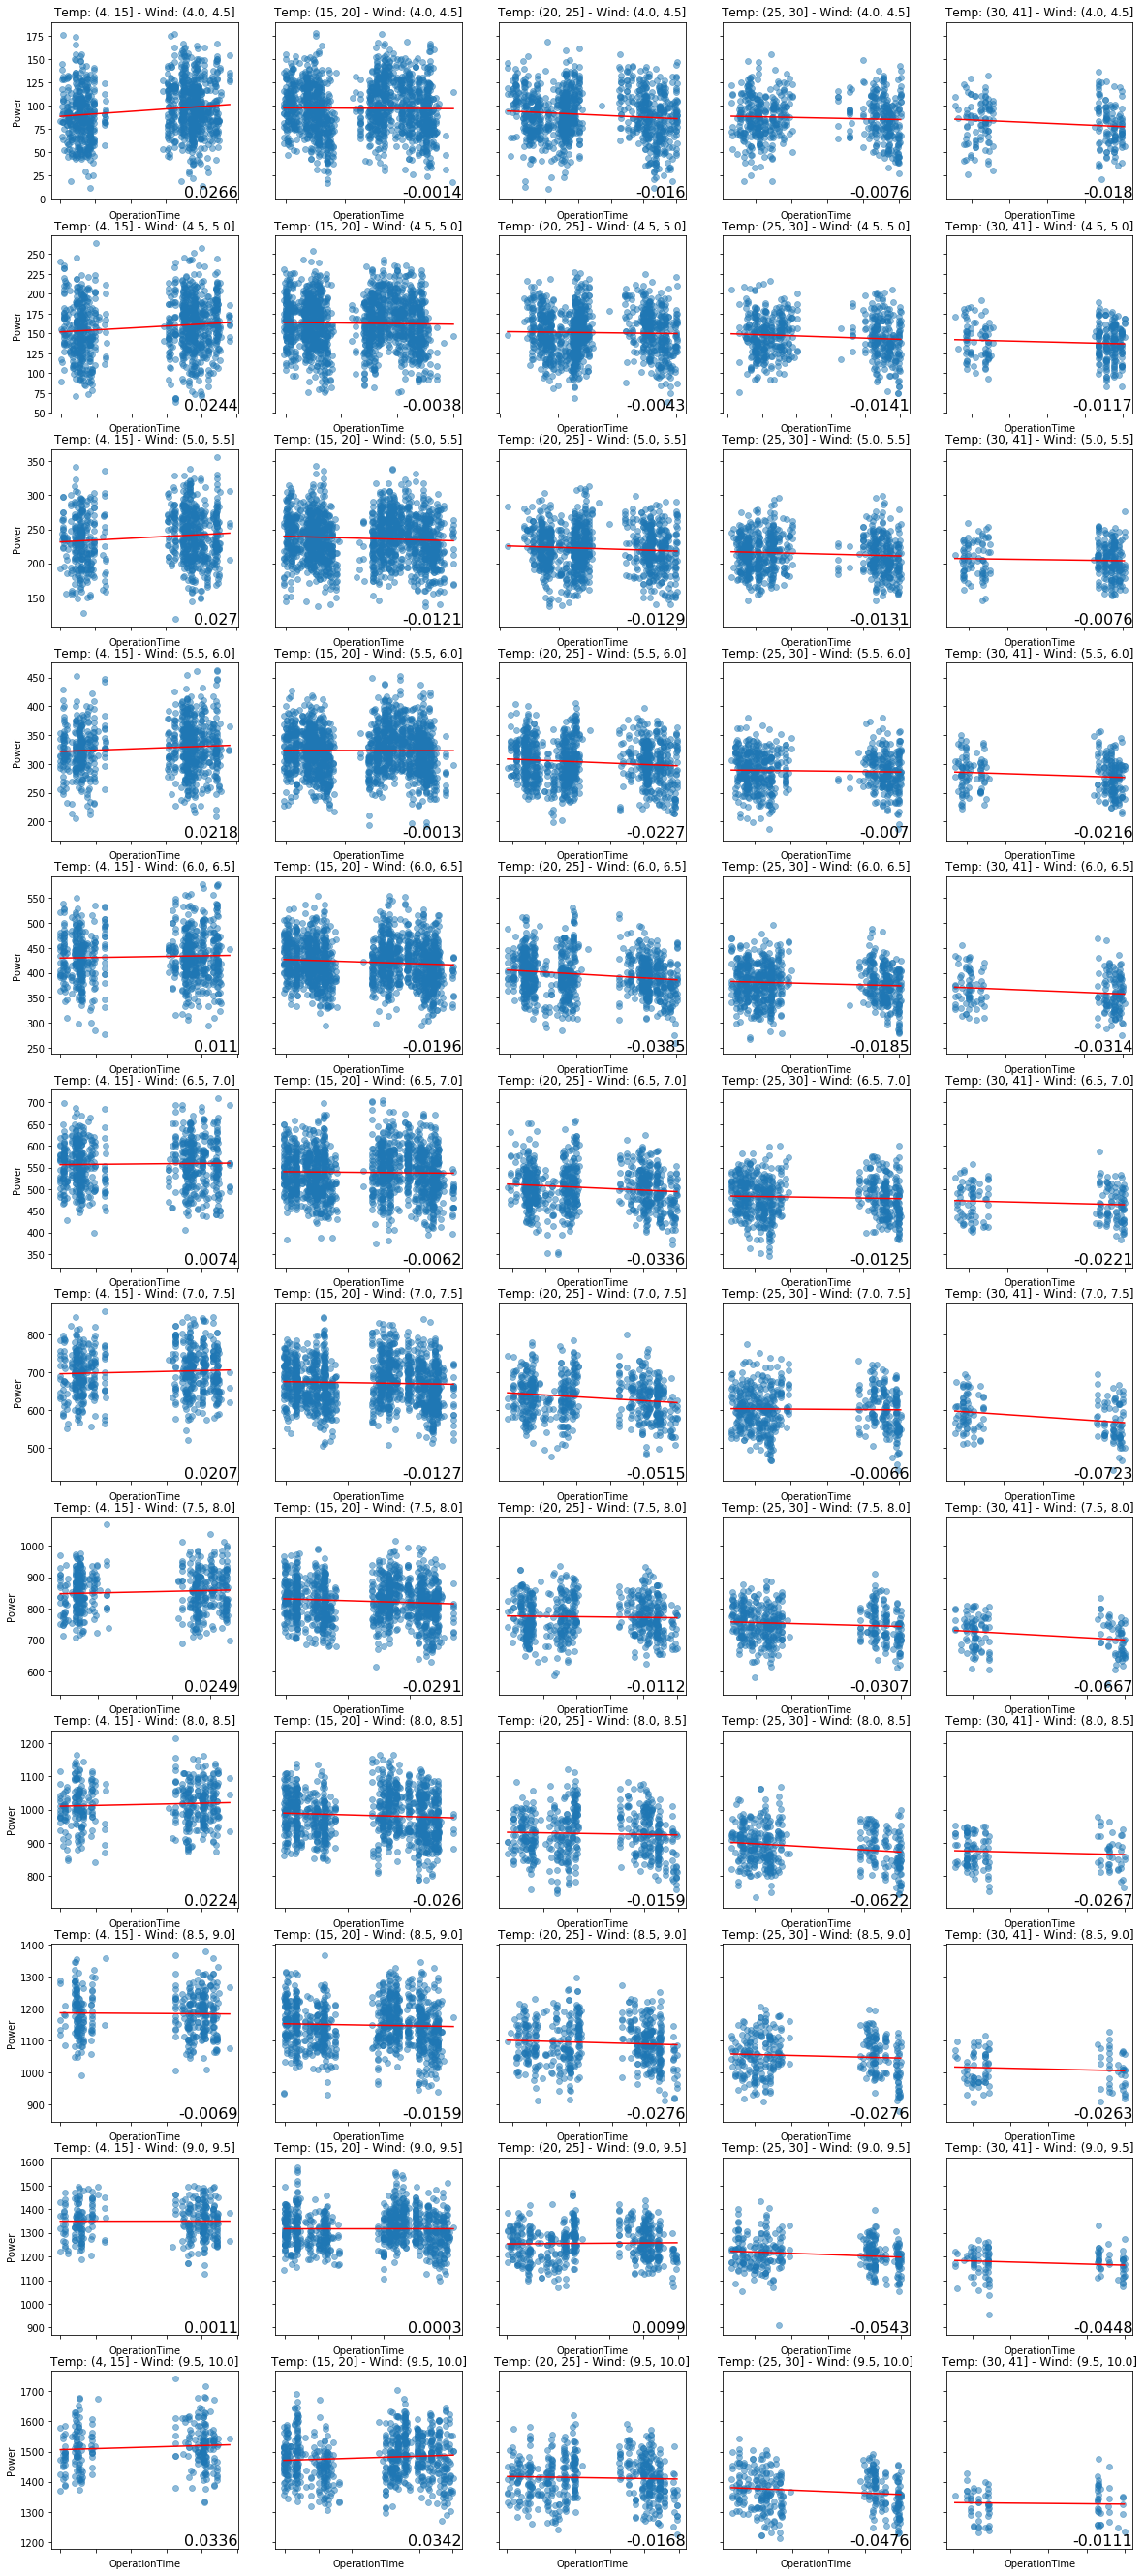

In [13]:
fig, axes = plt.subplots(12, 5, sharey = 'row', figsize = (20, 48))
batch_size = 30
res = np.zeros(60)
for i, (name, group) in enumerate(sliced_T01.groupby(by = ["Temp", "Wind"])):    
    # KMeans
    temp = group.reset_index()
    
    # calculate summary statistics
    data_mean, data_std = np.mean(temp.Power), np.std(temp.Power)
    # identify outliers
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    temp = temp[(temp['Power'] > lower) & (temp['Power'] < upper)]
    
    group_id = np.repeat(np.arange(0, temp.shape[0] // batch_size + 1, 1, dtype=int), batch_size)
    temp["index"] = group_id[:temp.shape[0]]
    temp["Avg_Power"] = temp.groupby(by="index")["Power"].transform("mean")
    #print(temp.head(10))
    model = _LinRegBasicModel(temp.Avg_Power, temp.OperationTime)
    snsplot = sns.scatterplot(ax = axes[i % 12, i // 12], 
                              x = temp.OperationTime, 
                              y = temp.Power, edgecolor = None, alpha = 0.5)
    snsplot.set(xticklabels=[])
    axes[i % 12, i // 12].plot(
        temp.OperationTime,
        model.beta[0] + model.beta[1] * temp.OperationTime, color="r")
    res[i]=model.beta[1]
    #axes[i % 12, i // 12].axis('equal')
    axes[i % 12, i // 12].annotate(round(model.beta[1],4), xy=(1, 0), xycoords='axes fraction', fontsize=16,
                horizontalalignment='right', verticalalignment='bottom')
    
    left_temp, right_temp = name[0].left, name[0].right
    left_wind, right_wind = name[1].left, name[1].right
    axes[i % 12, i // 12].set_title(f"Temp: ({left_temp}, {right_temp}] - Wind: ({left_wind}, {right_wind}]", fontsize=12)

In [14]:
sum(res<0)/len(res)

0.7666666666666667

## Ostatnia wersja dla T06

In [20]:
sliced_T06=slice_signals(signals, "T06", temp_bins=[4, 15, 20, 25, 30, 41])
sliced_T06["OperationTime"]=(sliced_T06.Time - np.datetime64("2016-01-01"))/np.timedelta64(1, 'D')
sliced_T06.head()

Wind     Temp  Power                Time  OperationTime
3629  (4.0, 4.5]  (4, 15]  110.5 2016-01-06 00:50:00       5.034722
4034  (4.0, 4.5]  (4, 15]  101.8 2016-01-06 14:20:00       5.597222
4262  (4.0, 4.5]  (4, 15]   86.0 2016-01-06 22:00:00       5.916667
6051  (4.0, 4.5]  (4, 15]  121.3 2016-01-09 09:40:00       8.402778
7712  (4.0, 4.5]  (4, 15]   91.0 2016-01-11 17:00:00      10.708333

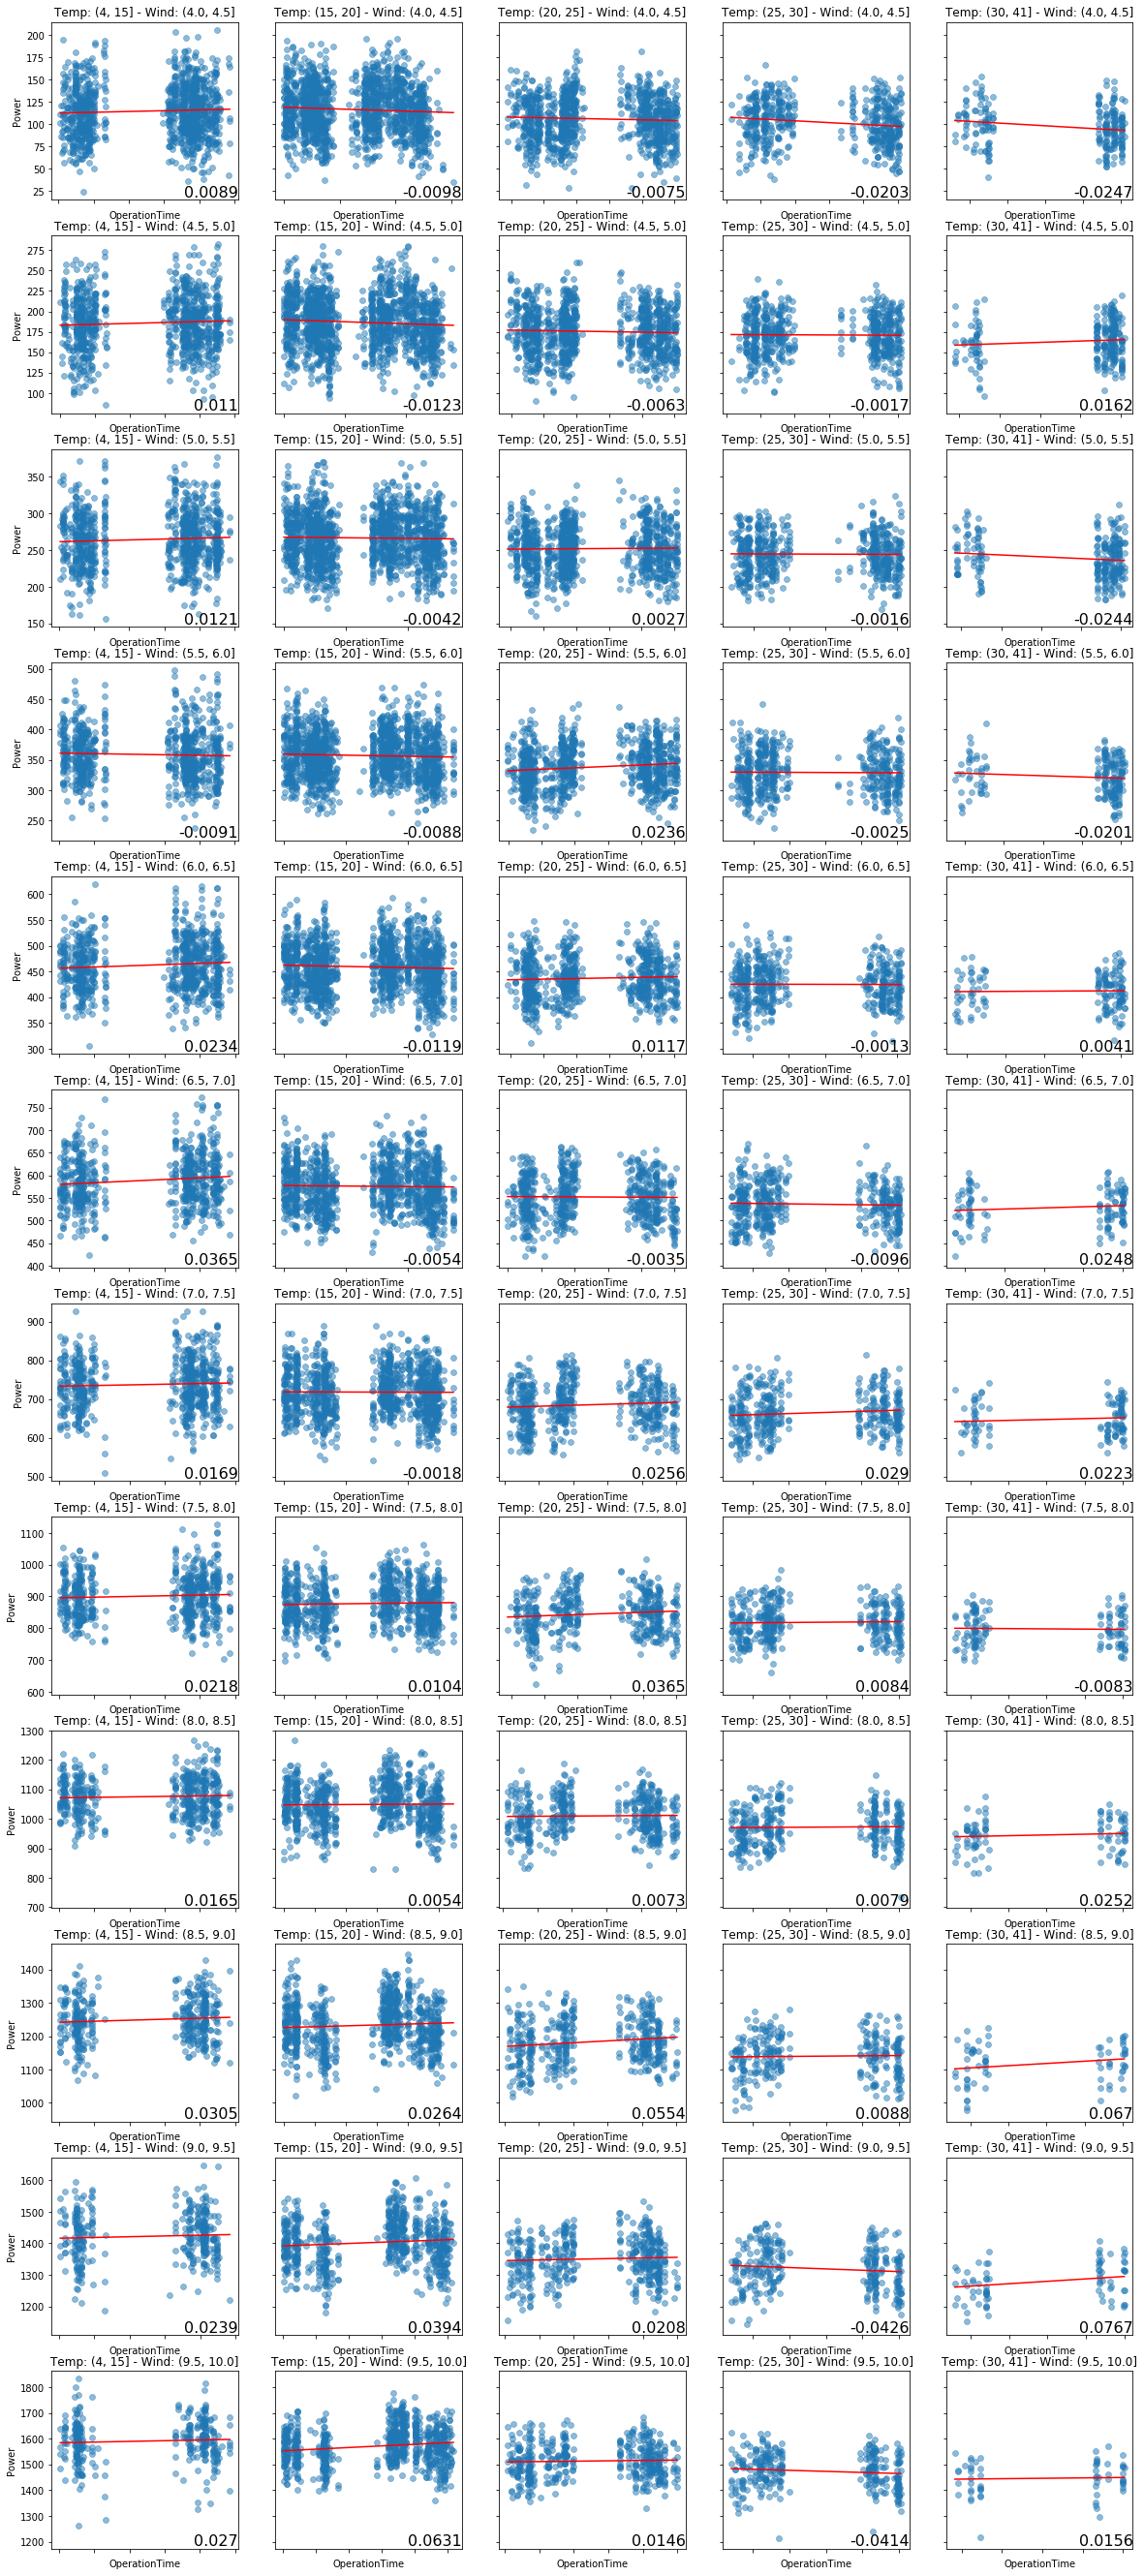

In [21]:
fig, axes = plt.subplots(12, 5, sharey = 'row', figsize = (20, 48))
batch_size = 30
res = np.zeros(60)
for i, (name, group) in enumerate(sliced_T06.groupby(by = ["Temp", "Wind"])):    
    # KMeans
    temp = group.reset_index()
    
    # calculate summary statistics
    data_mean, data_std = np.mean(temp.Power), np.std(temp.Power)
    # identify outliers
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    temp = temp[(temp['Power'] > lower) & (temp['Power'] < upper)]
    
    group_id = np.repeat(np.arange(0, temp.shape[0] // batch_size + 1, 1, dtype=int), batch_size)
    temp["index"] = group_id[:temp.shape[0]]
    temp["Avg_Power"] = temp.groupby(by="index")["Power"].transform("mean")
    #print(temp.head(10))
    model = _LinRegBasicModel(temp.Avg_Power, temp.OperationTime)
    snsplot = sns.scatterplot(ax = axes[i % 12, i // 12], 
                              x = temp.OperationTime, 
                              y = temp.Power, edgecolor = None, alpha = 0.5)
    snsplot.set(xticklabels=[])
    axes[i % 12, i // 12].plot(
        temp.OperationTime,
        model.beta[0] + model.beta[1] * temp.OperationTime, color="r")
    res[i]=model.beta[1]
    #axes[i % 12, i // 12].axis('equal')
    axes[i % 12, i // 12].annotate(round(model.beta[1],4), xy=(1, 0), xycoords='axes fraction', fontsize=16,
                horizontalalignment='right', verticalalignment='bottom')
    
    left_temp, right_temp = name[0].left, name[0].right
    left_wind, right_wind = name[1].left, name[1].right
    axes[i % 12, i // 12].set_title(f"Temp: ({left_temp}, {right_temp}] - Wind: ({left_wind}, {right_wind}]", fontsize=12)

In [22]:
sum(res<0)/len(res) #aj

0.38333333333333336

### T07

In [23]:
sliced_T07=slice_signals(signals, "T07", temp_bins=[4, 15, 20, 25, 30, 41])
sliced_T07["OperationTime"]=(sliced_T07.Time - np.datetime64("2016-01-01"))/np.timedelta64(1, 'D')
sliced_T07.head()

Wind     Temp  Power                Time  OperationTime
1044  (4.0, 4.5]  (4, 15]  143.8 2016-01-02 10:40:00       1.444444
1074  (4.0, 4.5]  (4, 15]   84.8 2016-01-02 11:40:00       1.486111
3639  (4.0, 4.5]  (4, 15]   47.6 2016-01-06 01:10:00       5.048611
4013  (4.0, 4.5]  (4, 15]   97.6 2016-01-06 13:40:00       5.569444
4027  (4.0, 4.5]  (4, 15]  113.5 2016-01-06 14:10:00       5.590278

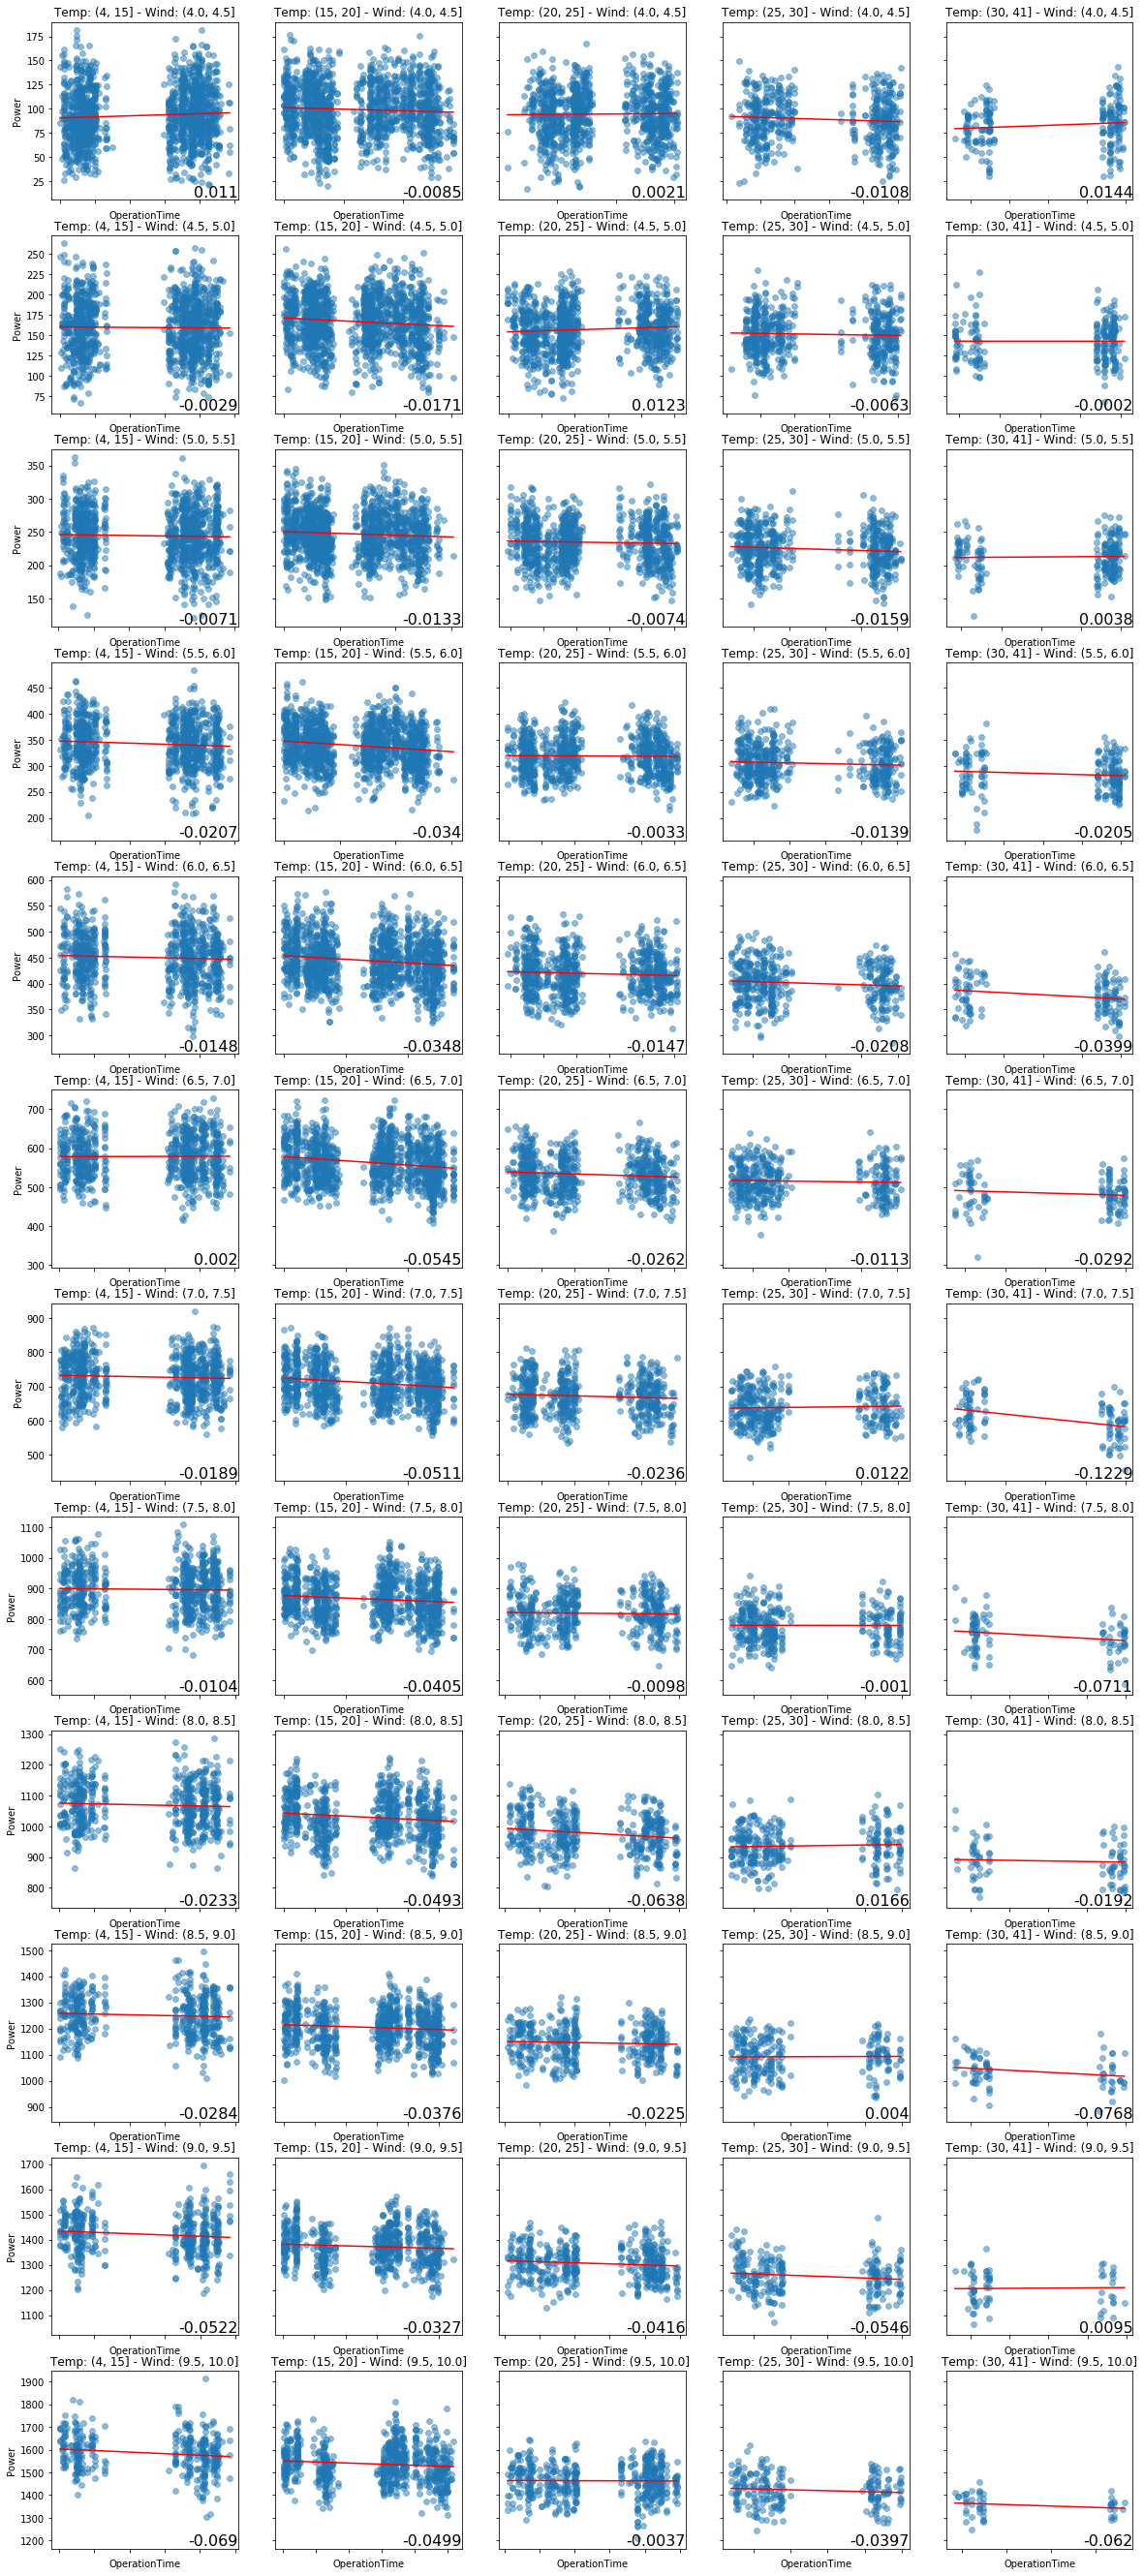

In [24]:
fig, axes = plt.subplots(12, 5, sharey = 'row', figsize = (20, 48))
batch_size = 30
res = np.zeros(60)
for i, (name, group) in enumerate(sliced_T07.groupby(by = ["Temp", "Wind"])):    
    # KMeans
    temp = group.reset_index()
    
    # calculate summary statistics
    data_mean, data_std = np.mean(temp.Power), np.std(temp.Power)
    # identify outliers
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    temp = temp[(temp['Power'] > lower) & (temp['Power'] < upper)]
    
    group_id = np.repeat(np.arange(0, temp.shape[0] // batch_size + 1, 1, dtype=int), batch_size)
    temp["index"] = group_id[:temp.shape[0]]
    temp["Avg_Power"] = temp.groupby(by="index")["Power"].transform("mean")
    #print(temp.head(10))
    model = _LinRegBasicModel(temp.Avg_Power, temp.OperationTime)
    snsplot = sns.scatterplot(ax = axes[i % 12, i // 12], 
                              x = temp.OperationTime, 
                              y = temp.Power, edgecolor = None, alpha = 0.5)
    snsplot.set(xticklabels=[])
    axes[i % 12, i // 12].plot(
        temp.OperationTime,
        model.beta[0] + model.beta[1] * temp.OperationTime, color="r")
    res[i]=model.beta[1]
    #axes[i % 12, i // 12].axis('equal')
    axes[i % 12, i // 12].annotate(round(model.beta[1],4), xy=(1, 0), xycoords='axes fraction', fontsize=16,
                horizontalalignment='right', verticalalignment='bottom')
    
    left_temp, right_temp = name[0].left, name[0].right
    left_wind, right_wind = name[1].left, name[1].right
    axes[i % 12, i // 12].set_title(f"Temp: ({left_temp}, {right_temp}] - Wind: ({left_wind}, {right_wind}]", fontsize=12)

In [26]:
sum(res<0)/len(res)

0.8333333333333334

### T09

In [27]:
sliced_T09=slice_signals(signals, "T09", temp_bins=[4, 15, 20, 25, 30, 41])
sliced_T09["OperationTime"]=(sliced_T09.Time - np.datetime64("2016-01-01"))/np.timedelta64(1, 'D')
sliced_T09.head()

Wind     Temp  Power                Time  OperationTime
1046  (4.0, 4.5]  (4, 15]  116.3 2016-01-02 10:50:00       1.451389
4028  (4.0, 4.5]  (4, 15]  110.7 2016-01-06 14:10:00       5.590278
4072  (4.0, 4.5]  (4, 15]  132.0 2016-01-06 15:40:00       5.652778
4175  (4.0, 4.5]  (4, 15]   82.7 2016-01-06 19:10:00       5.798611
4233  (4.0, 4.5]  (4, 15]   66.6 2016-01-06 21:00:00       5.875000

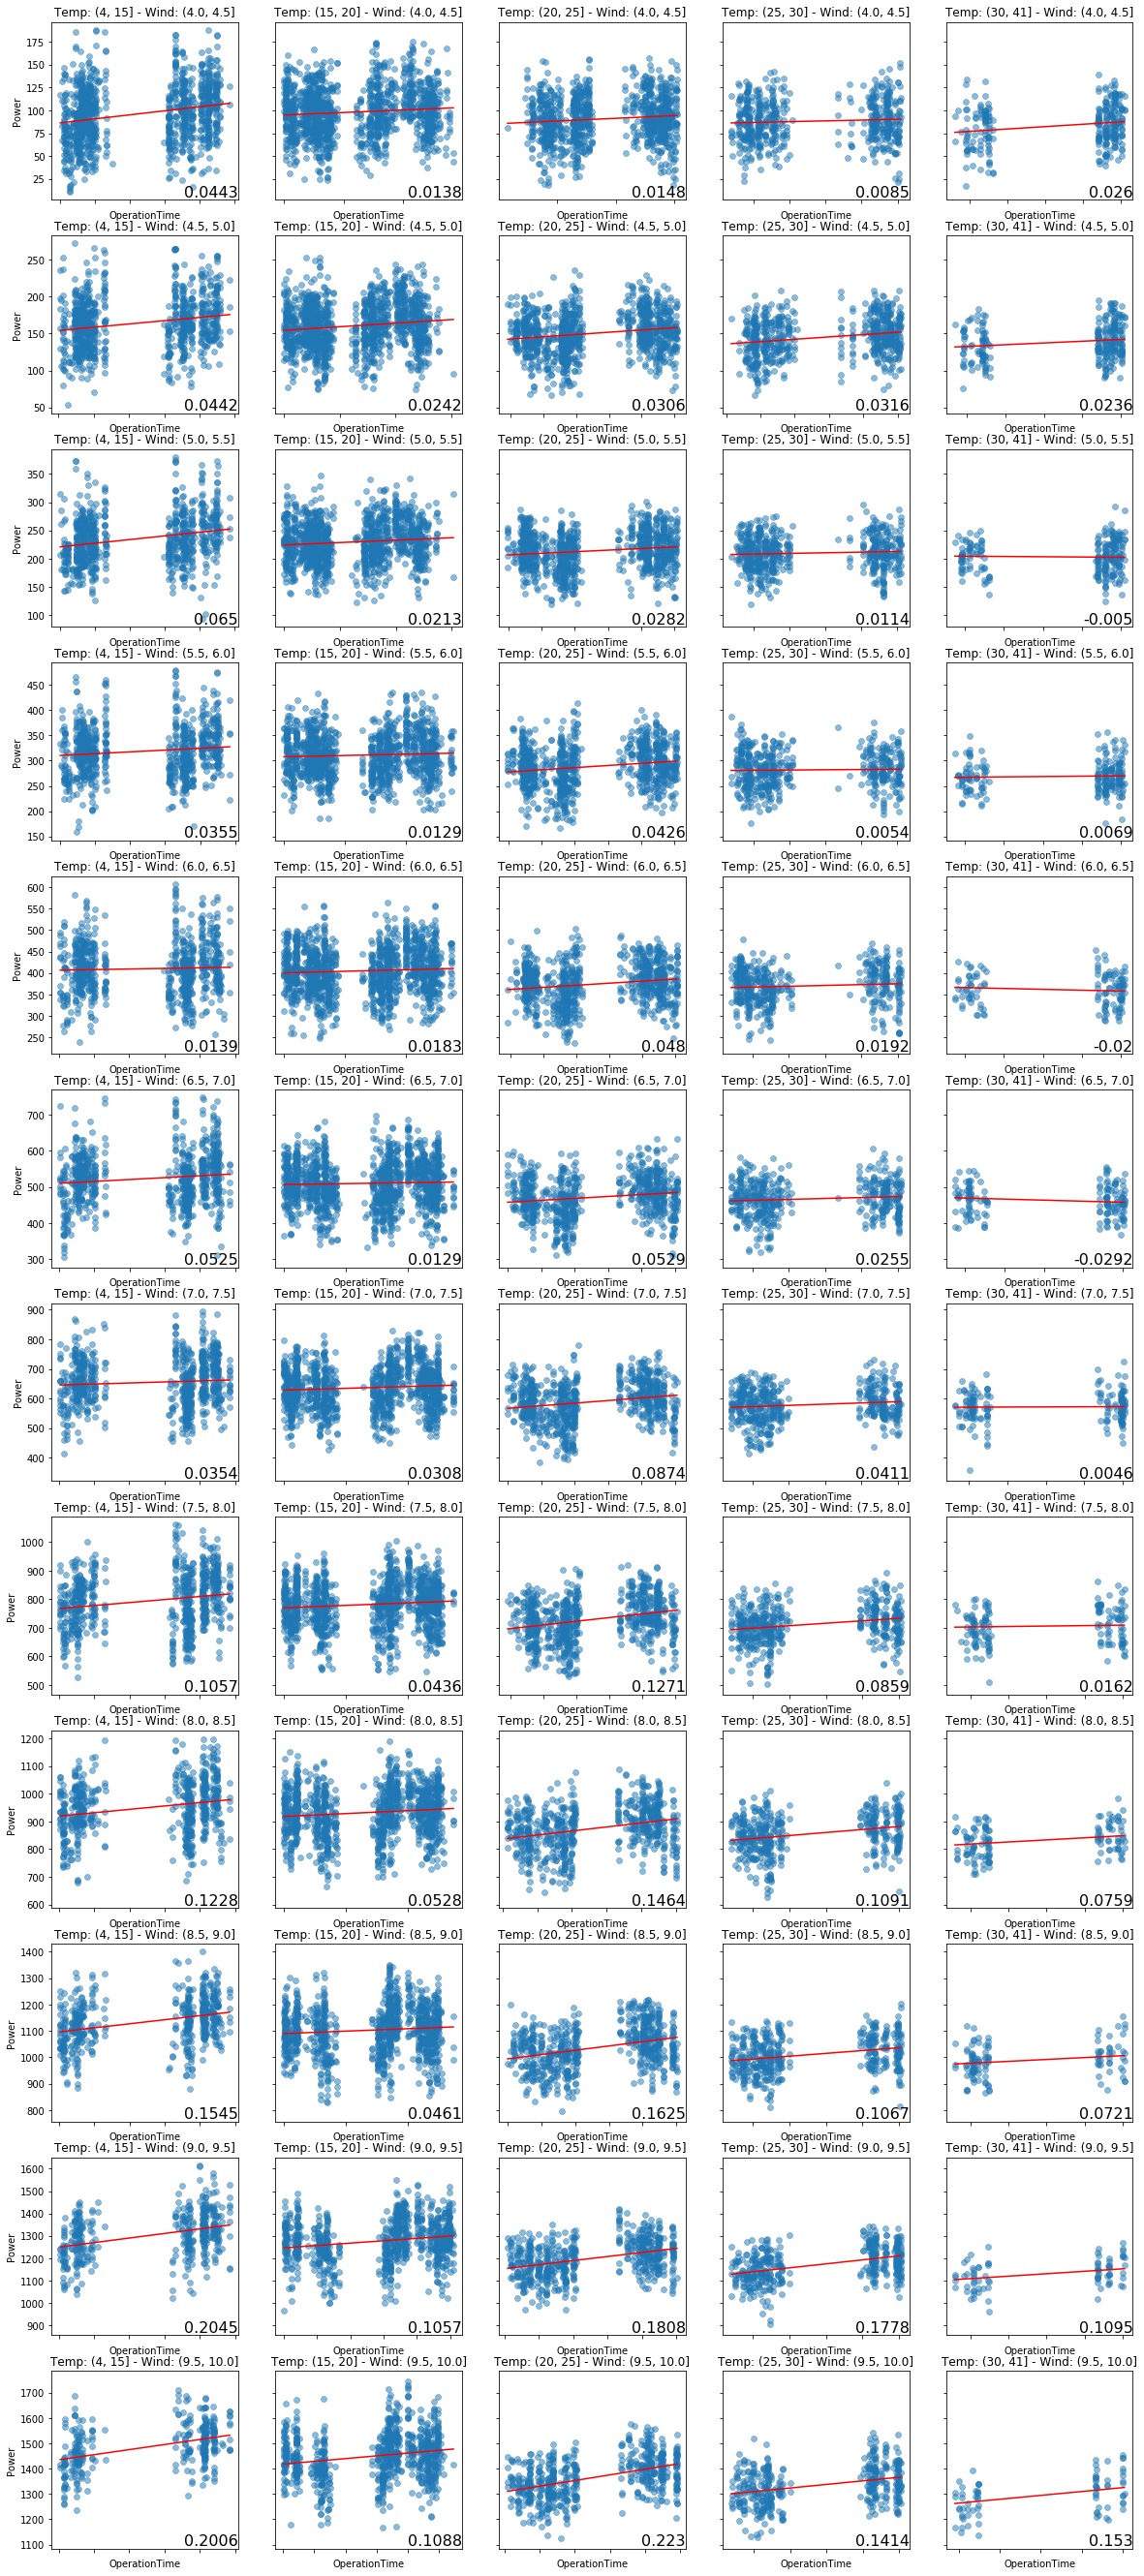

In [28]:
fig, axes = plt.subplots(12, 5, sharey = 'row', figsize = (20, 48))
batch_size = 30
res = np.zeros(60)
for i, (name, group) in enumerate(sliced_T09.groupby(by = ["Temp", "Wind"])):    
    # KMeans
    temp = group.reset_index()
    
    # calculate summary statistics
    data_mean, data_std = np.mean(temp.Power), np.std(temp.Power)
    # identify outliers
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    temp = temp[(temp['Power'] > lower) & (temp['Power'] < upper)]
    
    group_id = np.repeat(np.arange(0, temp.shape[0] // batch_size + 1, 1, dtype=int), batch_size)
    temp["index"] = group_id[:temp.shape[0]]
    temp["Avg_Power"] = temp.groupby(by="index")["Power"].transform("mean")
    #print(temp.head(10))
    model = _LinRegBasicModel(temp.Avg_Power, temp.OperationTime)
    snsplot = sns.scatterplot(ax = axes[i % 12, i // 12], 
                              x = temp.OperationTime, 
                              y = temp.Power, edgecolor = None, alpha = 0.5)
    snsplot.set(xticklabels=[])
    axes[i % 12, i // 12].plot(
        temp.OperationTime,
        model.beta[0] + model.beta[1] * temp.OperationTime, color="r")
    res[i]=model.beta[1]
    #axes[i % 12, i // 12].axis('equal')
    axes[i % 12, i // 12].annotate(round(model.beta[1],4), xy=(1, 0), xycoords='axes fraction', fontsize=16,
                horizontalalignment='right', verticalalignment='bottom')
    
    left_temp, right_temp = name[0].left, name[0].right
    left_wind, right_wind = name[1].left, name[1].right
    axes[i % 12, i // 12].set_title(f"Temp: ({left_temp}, {right_temp}] - Wind: ({left_wind}, {right_wind}]", fontsize=12)

In [29]:
sum(res<0)/len(res)

0.05

### T11

In [30]:
sliced_T11=slice_signals(signals, "T11", temp_bins=[4, 15, 20, 25, 30, 41])
sliced_T11["OperationTime"]=(sliced_T11.Time - np.datetime64("2016-01-01"))/np.timedelta64(1, 'D')
sliced_T11.head()

Wind     Temp  Power                Time  OperationTime
1065  (4.0, 4.5]  (4, 15]  115.4 2016-01-02 11:30:00       1.479167
3750  (4.0, 4.5]  (4, 15]   68.0 2016-01-06 05:00:00       5.208333
3766  (4.0, 4.5]  (4, 15]   49.3 2016-01-06 05:30:00       5.229167
3804  (4.0, 4.5]  (4, 15]   76.0 2016-01-06 06:40:00       5.277778
7700  (4.0, 4.5]  (4, 15]   67.2 2016-01-11 16:40:00      10.694444

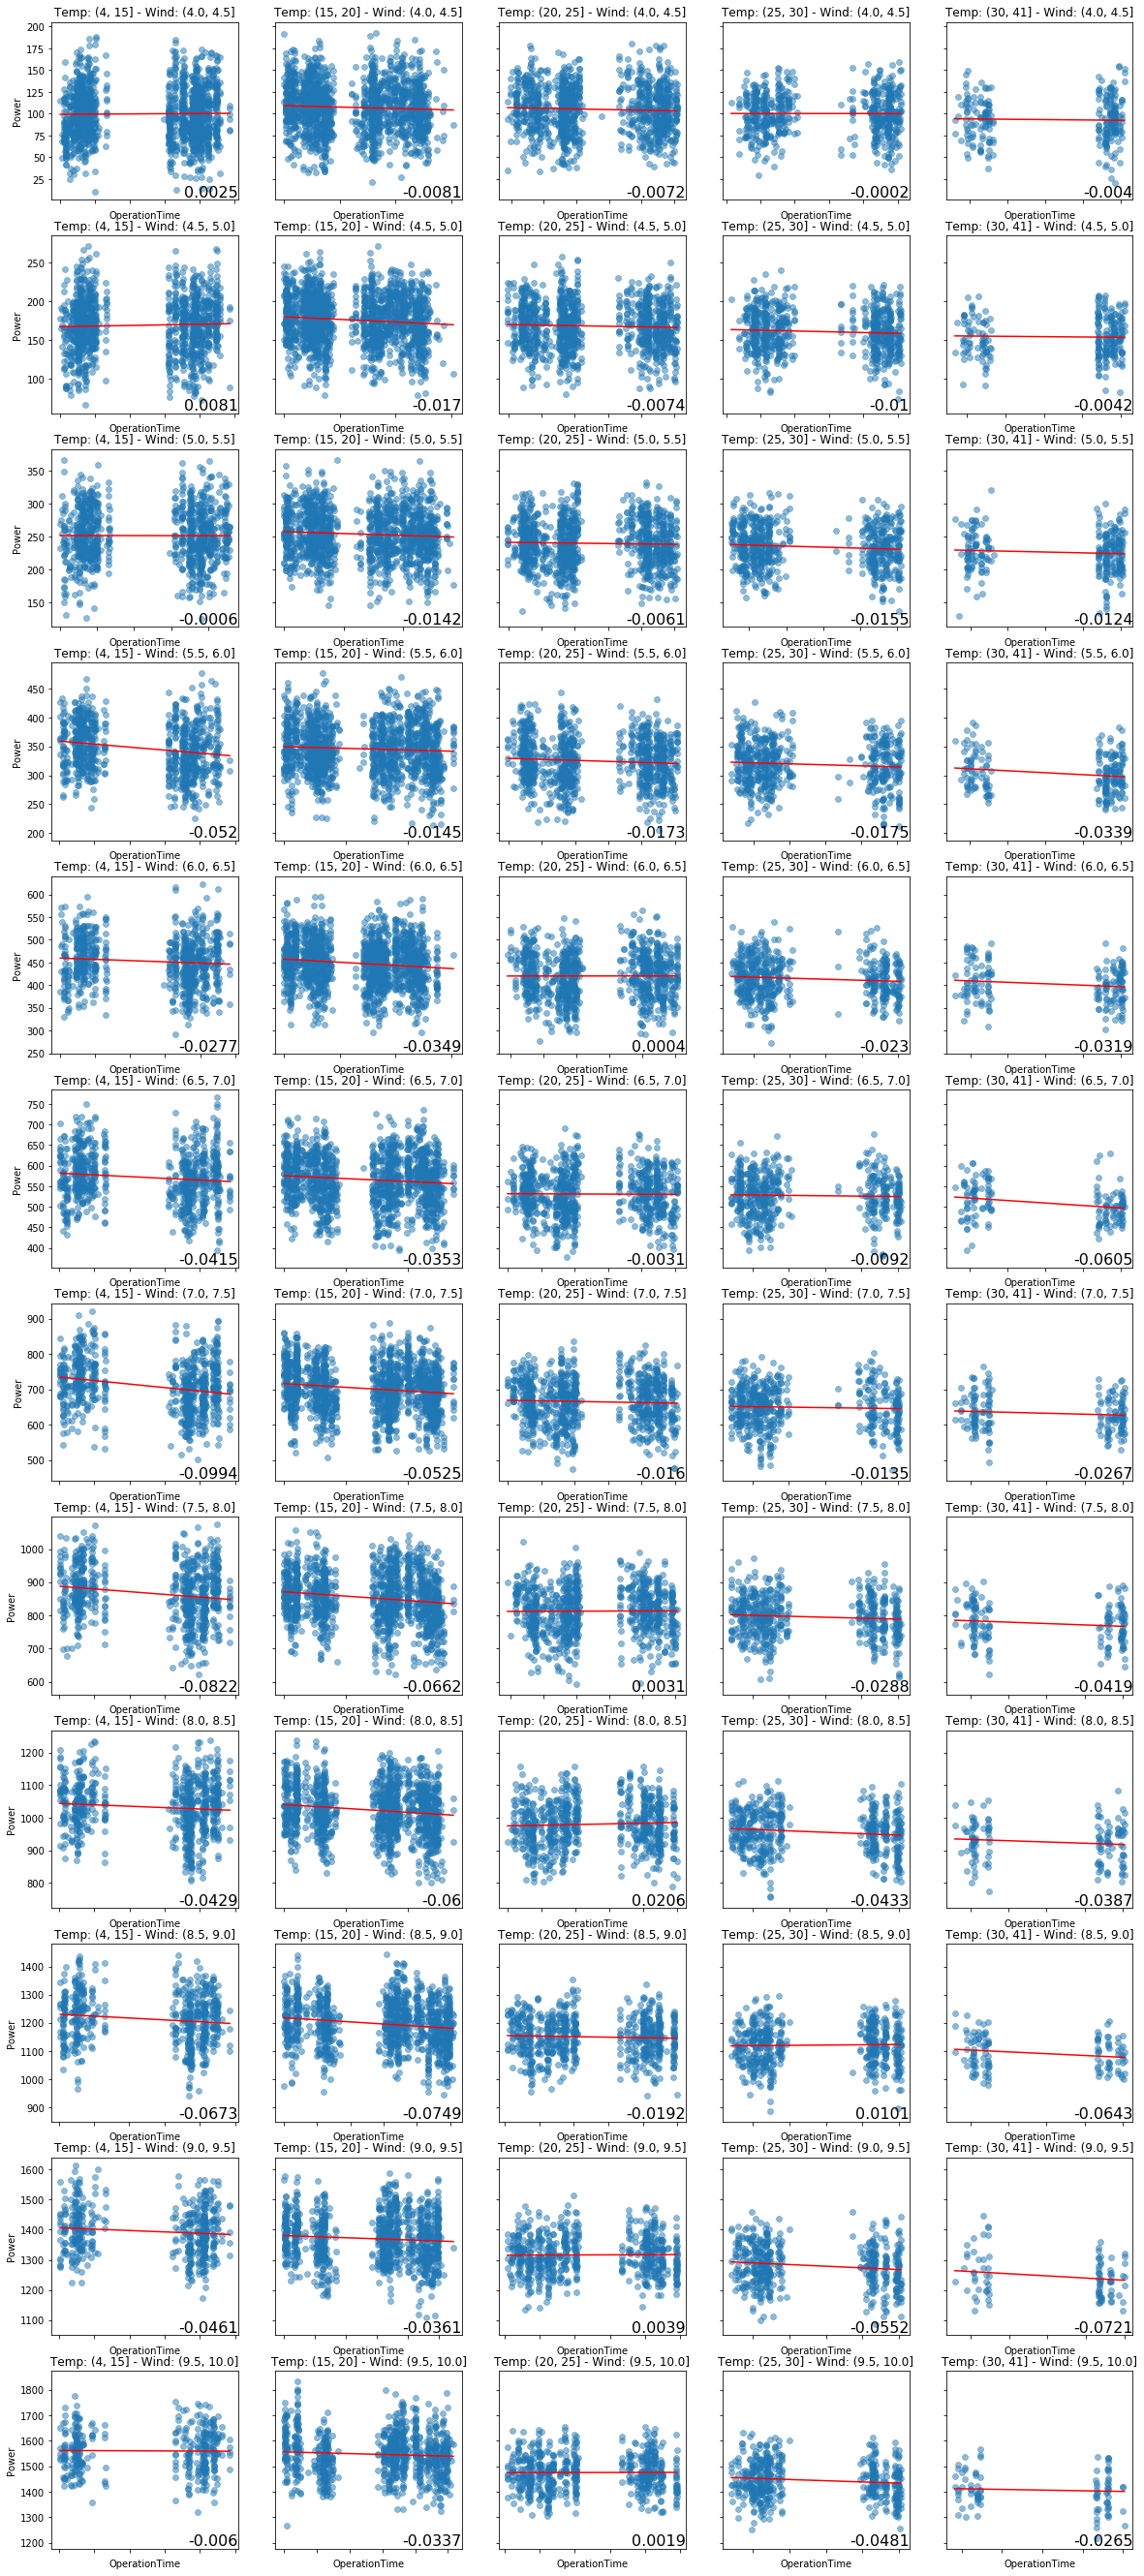

In [31]:
fig, axes = plt.subplots(12, 5, sharey = 'row', figsize = (20, 48))
batch_size = 30
res = np.zeros(60)
for i, (name, group) in enumerate(sliced_T11.groupby(by = ["Temp", "Wind"])):    
    # KMeans
    temp = group.reset_index()
    
    # calculate summary statistics
    data_mean, data_std = np.mean(temp.Power), np.std(temp.Power)
    # identify outliers
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    temp = temp[(temp['Power'] > lower) & (temp['Power'] < upper)]
    
    group_id = np.repeat(np.arange(0, temp.shape[0] // batch_size + 1, 1, dtype=int), batch_size)
    temp["index"] = group_id[:temp.shape[0]]
    temp["Avg_Power"] = temp.groupby(by="index")["Power"].transform("mean")
    #print(temp.head(10))
    model = _LinRegBasicModel(temp.Avg_Power, temp.OperationTime)
    snsplot = sns.scatterplot(ax = axes[i % 12, i // 12], 
                              x = temp.OperationTime, 
                              y = temp.Power, edgecolor = None, alpha = 0.5)
    snsplot.set(xticklabels=[])
    axes[i % 12, i // 12].plot(
        temp.OperationTime,
        model.beta[0] + model.beta[1] * temp.OperationTime, color="r")
    res[i]=model.beta[1]
    #axes[i % 12, i // 12].axis('equal')
    axes[i % 12, i // 12].annotate(round(model.beta[1],4), xy=(1, 0), xycoords='axes fraction', fontsize=16,
                horizontalalignment='right', verticalalignment='bottom')
    
    left_temp, right_temp = name[0].left, name[0].right
    left_wind, right_wind = name[1].left, name[1].right
    axes[i % 12, i // 12].set_title(f"Temp: ({left_temp}, {right_temp}] - Wind: ({left_wind}, {right_wind}]", fontsize=12)

In [32]:
sum(res<0)/len(res)

0.8666666666666667